In [110]:
source("~/software/notebook_assist/functions.R")
source("~/software/notebook_assist/packages.R")

setwd("/projects/CARDIPS/analysis/epigenome_resource/")


theme_bw2 = theme_bw() +
    theme(
        axis.text = element_text(size = 12),
        strip.text = element_text(size = 12),
        axis.title = element_text(size = 12),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 12),
        legend.position = "top"
    )


ipscore_gtex_leadvar_path="analyses/jennifer/ipscore_unique_qtls/mashr/2024_0911/input/ipscore_gtex_leadvars_stats.txt"
leads = fread(ipscore_gtex_leadvar_path,sep="\t",data.table = F)

In [111]:

mashr_result_path="analyses/jennifer/ipscore_unique_qtls/mashr/2024_0911/results/mashr_results.txt"## Found on Figshare
mashr = fread(mashr_result_path,sep="\t",data.table=F)

mashr$gene_id = str_extract(mashr$gene_variant, "^ENSG[0-9]+") 
mashr$variant_id = str_extract(mashr$gene_variant, "VAR_[0-9]+_[0-9]+_[A-Z]_[A-Z]") 

### calculate minimum lfsr for iPSCORE and GTEX tissues and across all tissues
mashr$min_ipscore_lfsr = rowMins(data.matrix(mashr[,6:8]))
mashr$min_adult_lfsr    = rowMins(data.matrix(mashr[,c(9:55)]))
mashr$min_lfsr         = rowMins(data.matrix(mashr[,c(6:55)]))

### filter SNP-eGene pairs that are not significant and not tested in both tissues
mashr2 = mashr[ mashr$min_lfsr <= 0.05 & mashr$ngtex_tested > 0 & mashr$nipscore_tested > 0 , ]

### assign temporal annotations to mashr output 
mashr2$Category = ifelse(mashr2$min_adult_lfsr <= 0.05 & mashr2$min_ipscore_lfsr <= 0.05, "Shared",
                              ifelse(mashr2$min_adult_lfsr >= 0.05 & mashr2$min_ipscore_lfsr <= 0.05, "EDev",
                                    ifelse(mashr2$min_adult_lfsr <= 0.05 & mashr2$min_ipscore_lfsr >= 0.05,
                                           "Adult", "Not Significant")))

mashr2$variant_id = gsub("VAR_","",str_extract(mashr2$gene_variant, "VAR_.*"))
table(mashr2$Category)


 Adult   EDev Shared 
 27881   2299  72195 

Warning message:
“The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. Please do this redirection yourself like reshape2::dcast(assigned_leads). In the next version, this warning will become an error.”
Warning message:
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(edev_cor). In the next version, this warning will become an error.”
Warning message:
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please 

QTL Specificity,mean_r
<fct>,<dbl>
EDev,0.001222009
Adult,0.006931362
Shared,0.278946015


[1] 2.942474e-22

[1] 4.784704e-126

[1] 5.772221e-128

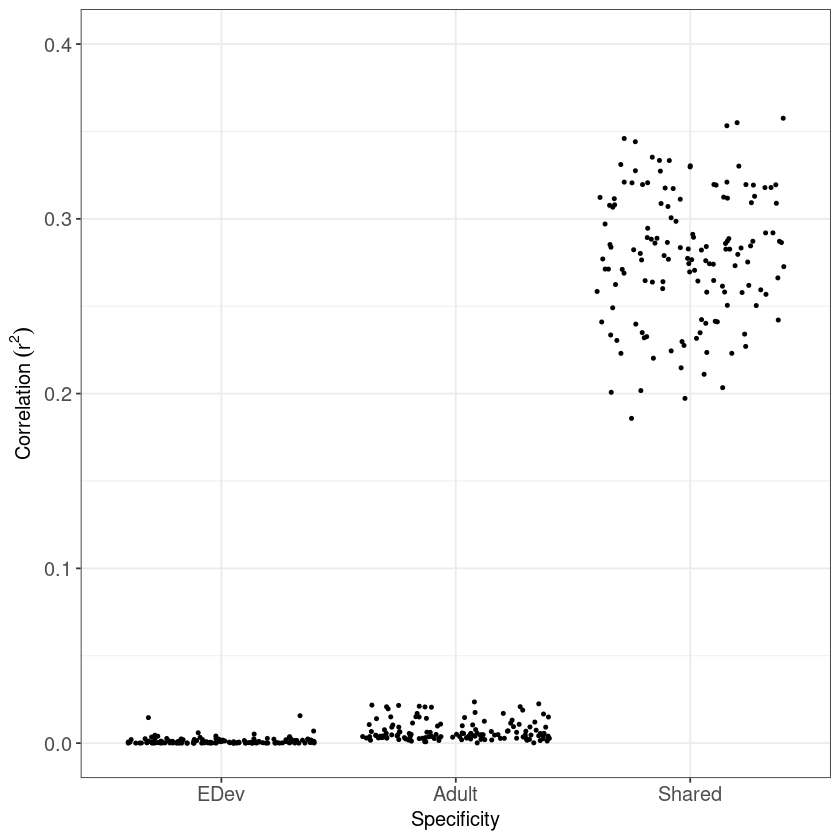

In [112]:
assigned_leads = leads[ leads$gene_variant %in% mashr2$gene_variant, ]

assigned_leads$Study = ifelse(assigned_leads$tissue %in% c("iPSC","CVPC","PPC"),
                             "iPSCORE","GTEx")
agged_leads = assigned_leads %>% group_by(gene_id, Study) %>% top_n(1,-log10(pval)) %>% sample_n(1)
assigned_leads2 = assigned_leads[ assigned_leads$gene_variant %in% agged_leads$gene_variant,]

lead_cast = dcast(gene_variant~ tissue, data = assigned_leads, fun.aggregate = sum,value.var = "beta")
rownames(lead_cast) = lead_cast$gene_variant
lead_cast$gene_variant = NULL
edev_cor = cor(lead_cast[ rownames(lead_cast) %in% mashr2$gene_variant[ mashr2$Category == "EDev"],])

shar_cor = cor(lead_cast[ rownames(lead_cast) %in% mashr2$gene_variant[ mashr2$Category == "Shared"],])
adult_cor = cor(lead_cast[ rownames(lead_cast) %in% mashr2$gene_variant[ mashr2$Category == "Adult"],])


edev_melt = melt(edev_cor)
edev_melt$Type = "EDev"
shar_melt = melt(shar_cor)
shar_melt$Type = "Shared"
adult_melt = melt(adult_cor)
adult_melt$Type = "Adult"

melted = rbind(rbind(edev_melt,shar_melt),adult_melt) %>% filter(Var1 != Var2)
melted$Tissue1 = as.character(melted$Var1)
melted$Tissue2 = as.character(melted$Var2)
melted$r2 = melted$value**2
melted$Var1 = NULL
melted$Var2 = NULL
melted2 = melted[!duplicated(apply(melted,1,function(x) paste(sort(x),collapse=''))),]
melted3 = melted2[ melted2$Tissue1 %in% c("iPSC","CVPC","PPC") |  melted2$Tissue2 %in% c("iPSC","CVPC","PPC"),]
melted4 = melted3 [ !(melted3$Tissue1 == "iPSC" &  melted3$Tissue2 == "CVPC") &
                     !(melted3$Tissue1 == "PPC" &  melted3$Tissue2 == "iPSC") &
                     !(melted3$Tissue1 == "PPC" &  melted3$Tissue2 == "CVPC"),]
melted4$`iPSCORE Tissue` = ifelse(melted4$Tissue1 %in% c("iPSC","CVPC","PPC"), melted4$Tissue1,
                                  ifelse(melted4$Tissue2 %in% c("iPSC","CVPC","PPC"), melted4$Tissue2, NA))
melted4$`iPSCORE Tissue` = factor(melted4$`iPSCORE Tissue`, levels = c("iPSC","CVPC","PPC"))
melted4$`QTL Specificity` = factor(melted4$Type, levels = c("EDev","Adult","Shared"))
melted4 %>% group_by(`QTL Specificity`) %>% summarise(mean_r = mean(r2))
    
ggplot(melted4, aes(`QTL Specificity`, r2, group=`QTL Specificity`)) + theme_bw2 + 
        ylim(c(0,0.4)) + xlab("Specificity") +
        ylab(bquote('Correlation'~(r^2))) +  geom_jitter(size=0.75) 
    
t.test(melted4$r2[ melted4$`QTL Specificity` == "EDev"],
      melted4$r2[ melted4$`QTL Specificity` == "Adult"])$p.value

t.test(melted4$r2[ melted4$`QTL Specificity` == "EDev"],
      melted4$r2[ melted4$`QTL Specificity` == "Shared"])$p.value

t.test(melted4$r2[ melted4$`QTL Specificity` == "Adult"],
      melted4$r2[ melted4$`QTL Specificity` == "Shared"])$p.value

In [113]:
library(readxl)
eqtls = read_xlsx("~/projects/Resource/RevisionTables/TableS4.xlsx") %>% 
            filter(QTL_Order == "Primary" & QTL_Type == "eQTL") %>% select(Tissue, Element_ID,Cluster_ID,SNP_ID, 
                                                                           SNP_Chromosome,SNP_Position,P_value,Effect_Size )
eqtls$tissue_element = paste(eqtls$Tissue, eqtls$Element_ID,sep="_")
eqtls$gene_variant = paste(str_extract(eqtls$Element_ID, "ENSG[0-9]+"),eqtls$SNP_ID)

eqtls$Category = ifelse(eqtls$gene_variant %in% mashr2$gene_variant[ mashr2$Category == "EDev"], "EDev",
                       ifelse(eqtls$gene_variant %in% mashr2$gene_variant[ mashr2$Category == "Shared"], "Shared","No Association"))

eqtls_temporal = eqtls[ eqtls$Category != "No Association",]

cat_dups = unique(eqtls_temporal[,c("Cluster_ID","Category")])
cat_dups = eqtls_temporal[ eqtls_temporal$Cluster_ID %in% names(table(eqtls_temporal$Cluster_ID ))[ 
                    table(eqtls_temporal$Cluster_ID ) > 1],]


no_assoc = eqtls$Cluster_ID[ eqtls$Category == "No Association"]
table(eqtls$Category)
eqtls$Stage_Specificity = ifelse(eqtls$Cluster_ID %in% no_assoc, "No Association",
                           ifelse(eqtls$Cluster_ID %in% cat_dups$Cluster_ID, "Shared",eqtls$Category)) 
table(eqtls$Stage_Specificity)
table(eqtls$Tissue,eqtls$Stage_Specificity)


table(eqtls$Stage_Specificity, eqtls$Tissue)    
eqtls$Tissue = factor(eqtls$Tissue, levels = c("iPSC","CVPC","PPC"))
psize(3,3)

wilcox.test(abs(eqtls$beta[ eqtls$Category == "EDev" & eqtls$tissue == "iPSC"]),
               abs(eqtls$beta[ eqtls$Category == "Shared"& eqtls$tissue == "iPSC"]))$p.value
wilcox.test(abs(eqtls$beta[ eqtls$Category == "EDev" & eqtls$tissue == "CVPC"]),
               abs(eqtls$beta[ eqtls$Category == "Shared"& eqtls$tissue == "CVPC"]))$p.value
wilcox.test(abs(eqtls$beta[ eqtls$Category == "EDev" & eqtls$tissue == "PPC"]),
               abs(eqtls$beta[ eqtls$Category == "Shared"& eqtls$tissue == "PPC"]))$p.value


          EDev No Association         Shared 
          2269           6038          10998 


          EDev No Association         Shared 
          2046           6542          10717 

      
       EDev No Association Shared
  CVPC  855           1158   2824
  iPSC  951           3224   4837
  PPC   240           2160   3056

In [ ]:
### Calculate EDev-specific GWAS

gwas = fread("~/projects/Resource/Figshare/all_results.qtl_coloc.2024_0925.txt",sep="\t",data.table=F)
gwas$Stage_specificity = ifelse(gwas$Cluster_ID %in% eqtls$Cluster_ID[ eqtls$Stage_Specificity == "EDev"],"EDev",
                   ifelse(gwas$Cluster_ID %in% eqtls$Cluster_ID[ eqtls$Stage_Specificity == "Shared"],"Shared","No association"))


gwas_index = unique(gwas[ grepl("eQTL",gwas$qtl_combo_collapse) ,c("Stage_specificity","index_trait") ])
shared_index = unique(gwas_index$index_trait[ gwas_index$Stage_specificity == "Shared"])
edev_index = unique(gwas_index$index_trait[ gwas_index$Stage_specificity == "EDev"])
gwas_index$Specificity_collapse = ifelse(gwas_index$index_trait %in% shared_index, "Shared",
                                        ifelse(gwas_index$index_trait %in% edev_index, "EDev","No association"))
gwas_index2 = unique(gwas_index[, c("Specificity_collapse","index_trait")])
sum(table(gwas_index2$Specificity_collapse))
table(gwas_index2$Specificity_collapse)